# Notebook to validate 0.1% went as it should have, in terms of data tracking, etc.
## Start by checking evolution of MTL files, finish with LSS catalogs

In [1]:
import fitsio
from astropy.table import Table,join,unique,vstack
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
from desitarget.io import read_targets_in_tiles

In [3]:
mdir = '/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv2/bright/' #location of ledgers
tdir = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.53.0/targets/sv2/resolve/bright/' #location of targets
mtld = Table.read('/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/mtl-done-tiles.ecsv') #log of tiles completed for mtl

In [4]:
#construct a table with the needed tile information
tilel = []
ral = []
decl = []
mtlt = []
fal = []
for tile in mtld['TILEID']:
    fht = fitsio.read_header('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/0'+str(tile)[:2]+'/fiberassign-0'+str(tile)+'.fits.gz')
    tilel.append(tile)
    ral.append(fht['TILERA'])
    decl.append(fht['TILEDEC'])
    mtlt.append(fht['MTLTIME'])
    fal.append(fht['FA_RUN'])
ta = Table()
ta['TILEID'] = tilel
ta['RA'] = ral
ta['DEC'] = decl
ta['MTLTIME'] = mtlt
ta['FA_RUN'] = fal

In [5]:
#this should provide most recent mtl information
tar = read_targets_in_tiles(mdir,ta,mtl=True)

In [6]:
#look at when all of the MTL updates happened
np.unique(tar['TIMESTAMP'])

array(['2021-03-18T23:11:27', '2021-03-18T23:11:32',
       '2021-03-18T23:11:37', '2021-03-26T21:20:28',
       '2021-03-29T20:16:49'], dtype='<U19')

In [7]:
#compare to when fiberassign queried the MTL to construct tiles
np.unique(ta['MTLTIME'])

2021-03-24T22:14:00
2021-03-24T22:15:22
2021-03-24T22:16:43
2021-03-24T22:17:54
2021-03-24T22:19:03
2021-03-24T22:20:12
2021-03-24T22:21:23
2021-03-24T22:22:27
2021-03-27T00:04:43
2021-03-27T00:05:38
2021-03-27T00:06:35


## We can see three dates for when the MTL was update and two for when fiberassign queried it
### Implies: intitial MTL -> 1st fiberassign run -> MTL updates -> 2nd fiberassign run -> final MTL update (what should be reflected in the array tar)

In [8]:
tar0 = read_targets_in_tiles(mdir,ta,mtl=True,isodate='2021-03-24T22:14:00') #first fiberassign time
tar1 = read_targets_in_tiles(mdir,ta,mtl=True,isodate='2021-03-27T22:14:00') #2nd fiberassign time

In [9]:
#check that tar0 has nothing observed yet
np.unique(tar0['NUMOBS'])

array([0])

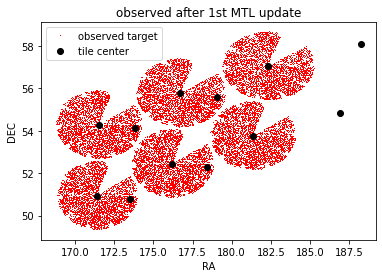

In [10]:
#plot observations after first update
wo1 = tar1['NUMOBS'] > 0
plt.plot(tar1[wo1]['RA'],tar1[wo1]['DEC'],'r,',label='observed target')
plt.plot(ral,decl,'ko',label='tile center')
plt.title('observed after 1st MTL update')
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

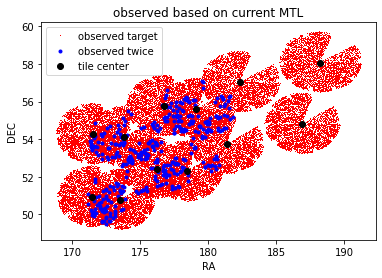

In [12]:
#observations according to current MTL
wo = tar['NUMOBS'] > 0
wo2 = tar['NUMOBS'] > 1
plt.plot(tar[wo]['RA'],tar[wo]['DEC'],'r,',label='observed target')
plt.plot(tar[wo2]['RA'],tar[wo2]['DEC'],'b.',label='observed twice')
plt.plot(ral,decl,'ko',label='tile center')
plt.title('observed based on current MTL')
plt.legend()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.show()

## The observed twice was a surprise to AJR, but that is apparently standard BGS behavior. After a successful observation, they allowed to be observed again, just at lower priority. This makes it convenient to see the overlap regions on the above plot.

### Now, just take a look at how different columns have evolved

In [17]:
mtls = [tar0,tar1,tar]
cols = ['NUMOBS_MORE','NUMOBS','TARGET_STATE','TIMESTAMP','VERSION','PRIORITY']
ct = 0
for tl in mtls:
    print('for round '+str(ct))
    for col in cols:
        print(col+ ': value number')
        nu = np.unique(tl[col],return_counts=True)
        for ii in range(0,len(nu[0])):
            print(nu[0][ii],nu[1][ii])
    ct +=1
    print('\n')

for round 0
NUMOBS_MORE: value number
0 23
1 157625
NUMOBS: value number
0 157648
TARGET_STATE: value number
BGS|UNOBS 106567
CALIB 23
MWS|UNOBS 51058
TIMESTAMP: value number
2021-03-18T23:11:27 91426
2021-03-18T23:11:32 6805
2021-03-18T23:11:37 59417
VERSION: value number
0.53.0 157648
PRIORITY: value number
0 23
1400 28427
1500 22141
1550 35
1600 165
2000 38673
2100 67894
2998 290


for round 1
NUMOBS_MORE: value number
0 2571
1 155077
NUMOBS: value number
0 139454
1 18194
TARGET_STATE: value number
BGS|MORE_ZGOOD 15640
BGS|MORE_ZWARN 971
BGS|UNOBS 89956
CALIB 23
MWS|DONE 1577
MWS|UNOBS 49481
TIMESTAMP: value number
2021-03-18T23:11:27 78427
2021-03-18T23:11:32 5623
2021-03-18T23:11:37 55404
2021-03-26T21:20:28 18194
VERSION: value number
0.53.0 139454
0.54.0 18194
PRIORITY: value number
0 23
2 2548
1000 15640
1400 28422
1500 20701
1550 35
1600 159
2000 36308
2100 53648
2998 164


for round 2
NUMOBS_MORE: value number
0 5305
1 152343
NUMOBS: value number
0 121626
1 35643
2 379
TARGET

## The above all seems reasonable, the specific numbers point out a few things:
* The version of targeting is changing. That is fine for SV2 (and very good it is being tracked) but we hope this is stable for the main survey.
* MWS targets really require tile overlaps to get observed
* 23 CALIB are in the MTL and start with NUMOBS=0; ADM says this expected (something about standard stars)
* NUMOBS_MORE = 0 is the sum of those 23 and those PRIORITY =2. The PRIORITY = 2 are MWS observations (target state MWS|DONE) and BGS redshift failures (target state BGS|MORE_ZWARN)
* This weird behavior with BGS and redshift failures was requested by C3 at some point. It won't be used for 1% but should perhaps be re-evaluated for the main survey

## Now check things match up with zbest files

In [18]:
#concatenate all zbest
specs = [0,1,2,3,4,5,6,7,8,9]
s = 0
for tile,zdate in zip(mtld['TILEID'],mtld['ZDATE']):
    for spec in specs:
        ff = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/'+str(tile)+'/'+zdate+'/zbest-'+str(spec)+'-'+str(tile)+'-thru'+zdate+'.fits'
        #print(ff)
        if os.path.isfile(ff):
            zfn = Table.read(ff,hdu='ZBEST')
            if s == 0:
                zf = zfn
                s = 1
            else:
                zf = vstack([zf,zfn])
        else:
            print('did not find '+ff)
        
    wz = zf['ZWARN'] == 0
    print(tile,len(zf),len(zf[wz]))

did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81056/20210324/zbest-6-81056-thru20210324.fits
81056 4500 3130
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81057/20210324/zbest-6-81057-thru20210324.fits
81057 9000 6287
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81058/20210324/zbest-6-81058-thru20210324.fits
81058 13500 9436
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81059/20210324/zbest-6-81059-thru20210324.fits
81059 18000 12541
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81060/20210324/zbest-6-81060-thru20210324.fits
81060 22500 15734
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81061/20210324/zbest-6-81061-thru20210324.fits
81061 27000 18912
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81062/20210327/zbest-6-81062-thru20210327.fits
81062 31500 22271
did not find /global/cfs/cdirs/desi/spe

In [19]:
#mtl file has columns for Z and ZWARN; null column is -1
print(np.unique(tar['Z']))
print(np.unique(tar['ZWARN']))

[-1.00000000e+00 -4.72950046e-03 -2.00000000e-03 ...  5.23410957e+00
  5.24905765e+00  5.47118187e+00]
[  -1    0    4   32   36 1024 1028 1056 1060 1570]


In [20]:
wz = tar['Z'] > -1
print(len(tar[wz]))
wz = tar['ZWARN'] > -1
print(len(tar[wz]))

36022
36022


In [26]:
#things are going to be a little awkward, because zbest file will contain repeats and mtl just more recent
print(len(zf))
print(len(np.unique(zf['TARGETID'])))
wz = zf['TARGETID'] > 0
print(len(zf[wz]))

54000
53257
45084


In [24]:
np.unique(zf['ZWARN'])

0
4
32
36
1024
1028
1056
1060
1570


In [32]:
zfu = unique(zf,keys=['TARGETID'])
ztar = join(tar,zfu,keys=['TARGETID'],join_type='left',table_names=['mtl','zbest'])

In [33]:
wz = ztar['ZWARN_zbest']*0 == 0 #unmatched columns will have nans here
print(len(ztar[wz]))

36022


### So the number of targets with redshift entries in the mtl indeed matches the number in the zbest files for the same targets. Entries in zbest with targetids not in the mtl are presumably skies/standards. The numbers imply an average of 83/petal: 9000/(12tiles 9petal/tiles). Check for consistency by going through fiberassign files

In [2]:
#start by just looking at one of the fiberassign files
fa = fitsio.FITS('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/081/fiberassign-081056.fits.gz')

In [3]:
fa


  file: /global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/081/fiberassign-081056.fits.gz
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       PRIMARY
  1      BINARY_TBL      FIBERASSIGN
  2      BINARY_TBL      SKY_MONITOR
  3      BINARY_TBL      GFA_TARGETS
  4      BINARY_TBL      TARGETS
  5      BINARY_TBL      POTENTIAL_ASSIGNMENTS

In [34]:
faa = fitsio.read('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/081/fiberassign-081056.fits.gz',ext='FIBERASSIGN')

In [33]:
faa.dtype.names

('TARGETID',
 'PETAL_LOC',
 'DEVICE_LOC',
 'LOCATION',
 'FIBER',
 'FIBERSTATUS',
 'TARGET_RA',
 'TARGET_DEC',
 'PMRA',
 'PMDEC',
 'REF_EPOCH',
 'LAMBDA_REF',
 'FA_TARGET',
 'FA_TYPE',
 'OBJTYPE',
 'FIBERASSIGN_X',
 'FIBERASSIGN_Y',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'RELEASE',
 'BRICKID',
 'BRICK_OBJID',
 'MORPHTYPE',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MASKBITS',
 'REF_ID',
 'REF_CAT',
 'GAIA_PHOT_G_MEAN_MAG',
 'GAIA_PHOT_BP_MEAN_MAG',
 'GAIA_PHOT_RP_MEAN_MAG',
 'PARALLAX',
 'BRICKNAME',
 'EBV',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'SERSIC',
 'SHAPE_R',
 'SHAPE_E1',
 'SHAPE_E2',
 'PHOTSYS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV2_DESI_TARGET',
 'SV2_BGS_TARGET',
 'SV2_MWS_TARGET',
 'SV2_SCND_TARGET',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET')

In [36]:
np.unique(faa['OBJTYPE'],return_counts=True)

(array(['', 'SKY', 'TGT'], dtype='<U3'), array([ 791,  800, 3409]))

In [65]:
np.min(faa['TARGETID'])

-406910646

In [67]:
ws = faa['FIBERSTATUS'] == 0
np.min(faa['TARGETID'][ws])

39633236183222245

In [37]:
fpa =  fitsio.read('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/081/fiberassign-081056.fits.gz',ext='POTENTIAL_ASSIGNMENTS')

In [35]:
len(fpa)

157772

In [66]:
np.min(fpa['TARGETID'])

39633236183222245

In [36]:
fpa.dtype.names

('TARGETID', 'FIBER', 'LOCATION')

In [39]:
fat = fitsio.read('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/081/fiberassign-081056.fits.gz',ext='TARGETS')

In [40]:
len(fat)

141541

In [41]:
fat.dtype.names

('TARGETID',
 'RA',
 'DEC',
 'FA_TARGET',
 'FA_TYPE',
 'PRIORITY',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'SV2_DESI_TARGET',
 'SV2_BGS_TARGET',
 'SV2_MWS_TARGET',
 'SV2_SCND_TARGET',
 'DESI_TARGET',
 'BGS_TARGET',
 'MWS_TARGET')

In [4]:
fh = fitsio.read_header('/global/cfs/cdirs/desi/target/fiberassign/tiles/trunk/081/fiberassign-081056.fits.gz')

In [5]:
fh


SIMPLE  =                    T / file does conform to FITS standard
BITPIX  =                   16 / number of bits per data pixel
NAXIS   =                    0 / number of data axes
EXTEND  =                    T / FITS dataset may contain extensions
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
EXTNAME = 'PRIMARY'            / 
TILEID  =                81056 / 
TILERA  =              171.407 / 
TILEDEC =               50.926 / 
FIELDROT=   0.0290585541908356 / 
FA_PLAN = '2022-07-01T00:00:00.000' / 
FA_HA   =                  0.0 / 
FA_RUN  = '2021-03-17T23:20:01' / 
REQRA   =              171.407 / 
REQDEC  =               50.926 / 
FIELDNUM=                    0 / 
FA_VER  = '2.1.1.dev2706'      / 
FA_SURV = 'sv2'                / 
DEPNAM00= 'python'             / 
DEPVER00= '3.8.3'              / 
DEPNAM01= 'numpy'              / 
DEPVER01= '1.19.1'             / 
D

In [89]:
len(tar)

157648

In [90]:
tar.dtype.names

('RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'TARGETID',
 'SV2_DESI_TARGET',
 'SV2_BGS_TARGET',
 'SV2_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV2_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

array(['2021-03-18T23:11:27', '2021-03-18T23:11:32',
       '2021-03-18T23:11:37', '2021-03-26T21:20:28',
       '2021-03-29T20:16:49'], dtype='<U19')

In [92]:
np.unique(ta['MTLTIME'])

2021-03-24T22:14:00
2021-03-24T22:15:22
2021-03-24T22:16:43
2021-03-24T22:17:54
2021-03-24T22:19:03
2021-03-24T22:20:12
2021-03-24T22:21:23
2021-03-24T22:22:27
2021-03-27T00:04:43
2021-03-27T00:05:38
2021-03-27T00:06:35


The MTL was updated on three different dates, we can check how it evolves

In [97]:
#confirm they are the same length and targetid column identical
print(len(tar),len(tar0))
print(np.array_equal(tar['TARGETID'],tar0['TARGETID']))

157648 157648
True


36011


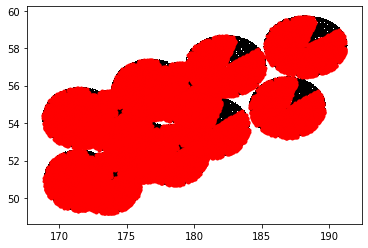

In [98]:
#plot the location of targets whose priorities have changed
wc = tar['PRIORITY'] != tar0['PRIORITY']
print(len(tar[wc]))
plt.plot(tar['RA'],tar['DEC'],'k,')
plt.plot(tar[wc]['RA'],tar[wc]['DEC'],'r.')
plt.show()

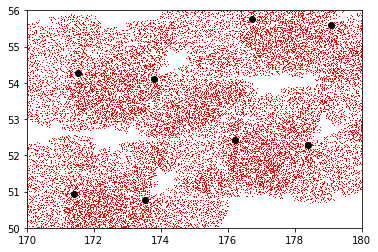

In [102]:
#zoom in on overlapping area
#plt.plot(tar['RA'],tar['DEC'],'k,')
plt.plot(tar[wc]['RA'],tar[wc]['DEC'],'r,')
plt.plot(ral,decl,'ko')
plt.xlim(170,180)
plt.ylim(50,56)
plt.show()

In [104]:
print(np.unique(tar0['NUMOBS']))
print(np.unique(tar['NUMOBS']))

[0]
[0 1 2]


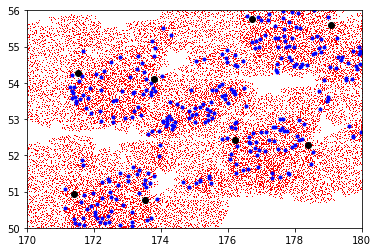

In [107]:
wo = tar['NUMOBS'] > 0
wo2 = tar['NUMOBS'] > 1
plt.plot(tar[wo]['RA'],tar[wo]['DEC'],'r,')
plt.plot(tar[wo2]['RA'],tar[wo2]['DEC'],'b.')
plt.plot(ral,decl,'ko')
plt.xlim(170,180)
plt.ylim(50,56)
plt.show()

In [109]:
print(np.unique(tar1['NUMOBS']))

[0 1]


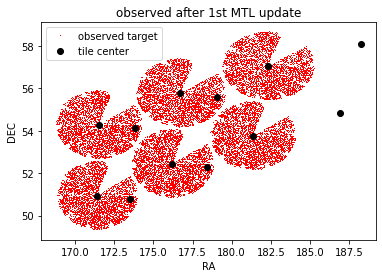

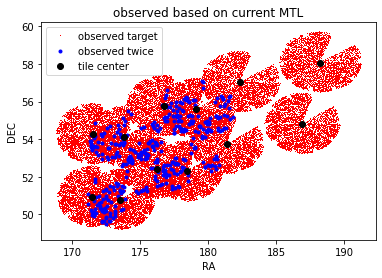

In [21]:
w = tar['ZWARN'] == 0
len(tar[w])

0

In [22]:
np.unique(tar['ZWARN'])

array([-1])

In [24]:
mtld.columns

<TableColumns names=('TILEID','TIMESTAMP','VERSION','PROGRAM','ZDATE')>

In [26]:
np.unique(mtld['ZDATE'])

20210324
20210326
20210327


In [27]:
mtld[0]

TILEID,TIMESTAMP,VERSION,PROGRAM,ZDATE
,s,,,
int32,str19,str6,str6,str8
81056,2021-03-26T21:20:18,0.54.0,BRIGHT,20210324


In [54]:
np.unique(mtld['TIMESTAMP'])

2021-03-26T21:20:18
2021-03-29T20:16:40


did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81056/20210324/zbest-6-81056-thru20210324.fits
81056 4500 3130
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81057/20210324/zbest-6-81057-thru20210324.fits
81057 9000 6287
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81058/20210324/zbest-6-81058-thru20210324.fits
81058 13500 9436
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81059/20210324/zbest-6-81059-thru20210324.fits
81059 18000 12541
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81060/20210324/zbest-6-81060-thru20210324.fits
81060 22500 15734
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81061/20210324/zbest-6-81061-thru20210324.fits
81061 27000 18912
did not find /global/cfs/cdirs/desi/spectro/redux/daily/tiles/cumulative/81062/20210327/zbest-6-81062-thru20210327.fits
81062 31500 22271
did not find /global/cfs/cdirs/desi/spe

In [136]:
ztar2 = join(tar,zf,keys=['TARGETID'])

In [154]:
#len(np.unique(ztar['TARGETID']))
len(ztar)

157648

In [129]:
plt.plot(tar['RA'],tar['DEC'],'k,')
plt.plot()

In [156]:
wz = ztar['Z']*0 == 0
len(ztar[wz])

36022

In [159]:
len(ztar[wo2])

379

(array([282., 119., 266., 417., 323., 324., 338., 389., 436., 371., 357.,
        599., 391., 363., 468., 332., 311., 259., 136., 158., 149., 117.,
         91.,  62.,  77.,  82.,  43.,  32.,  23.,  15.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 ]),
 <a list of 30 Patch objects>)

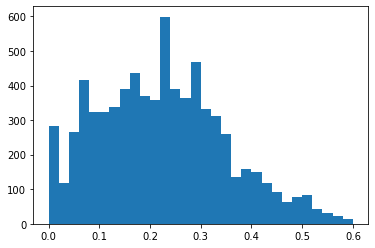

In [158]:
plt.hist(ztar[wo]['Z'],bins=30,range=(0,.6))

In [130]:
len(ztar)

158027

In [133]:
len(zf)
wz = zf['ZWARN']*0 == 0
len(zf[wz])

54000

In [135]:
len(np.unique(zf['TARGETID']))

53257

In [69]:
z0.dtype.names

('TARGETID',
 'CHI2',
 'COEFF',
 'Z',
 'ZERR',
 'ZWARN',
 'NPIXELS',
 'SPECTYPE',
 'SUBTYPE',
 'NCOEFF',
 'DELTACHI2',
 'NUMEXP',
 'NUMTILE')

In [43]:
tarp.dtype.names

('RA',
 'DEC',
 'REF_EPOCH',
 'PARALLAX',
 'PMRA',
 'PMDEC',
 'TARGETID',
 'SV2_DESI_TARGET',
 'SV2_BGS_TARGET',
 'SV2_MWS_TARGET',
 'SUBPRIORITY',
 'OBSCONDITIONS',
 'PRIORITY_INIT',
 'NUMOBS_INIT',
 'SV2_SCND_TARGET',
 'NUMOBS_MORE',
 'NUMOBS',
 'Z',
 'ZWARN',
 'ZTILEID',
 'TARGET_STATE',
 'TIMESTAMP',
 'VERSION',
 'PRIORITY')

In [46]:
from desitarget.mtl import inflate_ledger

In [52]:
tari = inflate_ledger(tar,tdir)

In [49]:
mdir

'/global/cfs/cdirs/desi/survey/ops/surveyops/trunk/mtl/sv2/bright/'

In [53]:
tari.dtype.names

('RELEASE',
 'BRICKID',
 'BRICKNAME',
 'BRICK_OBJID',
 'MORPHTYPE',
 'RA',
 'RA_IVAR',
 'DEC',
 'DEC_IVAR',
 'DCHISQ',
 'EBV',
 'FLUX_G',
 'FLUX_R',
 'FLUX_Z',
 'FLUX_IVAR_G',
 'FLUX_IVAR_R',
 'FLUX_IVAR_Z',
 'MW_TRANSMISSION_G',
 'MW_TRANSMISSION_R',
 'MW_TRANSMISSION_Z',
 'FRACFLUX_G',
 'FRACFLUX_R',
 'FRACFLUX_Z',
 'FRACMASKED_G',
 'FRACMASKED_R',
 'FRACMASKED_Z',
 'FRACIN_G',
 'FRACIN_R',
 'FRACIN_Z',
 'NOBS_G',
 'NOBS_R',
 'NOBS_Z',
 'PSFDEPTH_G',
 'PSFDEPTH_R',
 'PSFDEPTH_Z',
 'GALDEPTH_G',
 'GALDEPTH_R',
 'GALDEPTH_Z',
 'FLUX_W1',
 'FLUX_W2',
 'FLUX_W3',
 'FLUX_W4',
 'FLUX_IVAR_W1',
 'FLUX_IVAR_W2',
 'FLUX_IVAR_W3',
 'FLUX_IVAR_W4',
 'MW_TRANSMISSION_W1',
 'MW_TRANSMISSION_W2',
 'MW_TRANSMISSION_W3',
 'MW_TRANSMISSION_W4',
 'ALLMASK_G',
 'ALLMASK_R',
 'ALLMASK_Z',
 'FIBERFLUX_G',
 'FIBERFLUX_R',
 'FIBERFLUX_Z',
 'FIBERTOTFLUX_G',
 'FIBERTOTFLUX_R',
 'FIBERTOTFLUX_Z',
 'REF_EPOCH',
 'WISEMASK_W1',
 'WISEMASK_W2',
 'MASKBITS',
 'LC_FLUX_W1',
 'LC_FLUX_W2',
 'LC_FLUX_IVAR_W1',
 'LC

In [55]:
np.unique(tar['NUMOBS_MORE'])

array([0, 1])

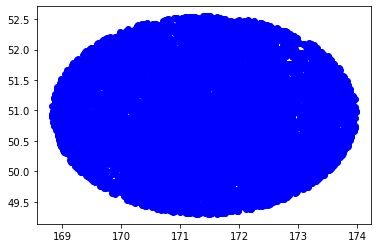

In [61]:
w = tar['NUMOBS_MORE'] == 0

plt.plot(tar['RA'][wt],tar['DEC'][wt],'bo')
plt.plot(tar['RA'][wt&w],tar['DEC'][wt&w],'ro')

In [58]:
tar[w]

array([(168.98753324, 50.84939481, 2015.5, 0.39154738,  -1.1197684, -4.096409, 39633259549687989, 42949672960, 0, 0, 0.4308946 , 7, -1, -1, 0, 0, 0, -1., -1, -1, 'CALIB', '2021-03-18T23:11:27', '0.53.0', 0),
       (170.7348222 , 50.37833763, 2015.5, 0.38275424,   2.8088198, -8.298147, 39633255720289739, 42949672960, 0, 0, 0.19171284, 7, -1, -1, 0, 0, 0, -1., -1, -1, 'CALIB', '2021-03-18T23:11:27', '0.53.0', 0),
       (170.63031623, 51.21042137, 2015.5, 0.29866326, -19.789991 , -5.215297, 39633267195905594, 42949672960, 0, 0, 0.5963911 , 7, -1, -1, 0, 0, 0, -1., -1, -1, 'CALIB', '2021-03-18T23:11:27', '0.53.0', 0)],
      dtype=[('RA', '<f8'), ('DEC', '<f8'), ('REF_EPOCH', '<f4'), ('PARALLAX', '<f4'), ('PMRA', '<f4'), ('PMDEC', '<f4'), ('TARGETID', '<i8'), ('SV2_DESI_TARGET', '<i8'), ('SV2_BGS_TARGET', '<i8'), ('SV2_MWS_TARGET', '<i8'), ('SUBPRIORITY', '<f8'), ('OBSCONDITIONS', '<i4'), ('PRIORITY_INIT', '<i8'), ('NUMOBS_INIT', '<i8'), ('SV2_SCND_TARGET', '<i8'), ('NUMOBS_MORE', '<i8')

In [59]:
wt = tar['SV2_BGS_TARGET'] > 0
len(tar[wt])

12581

In [60]:
len(tar)

18333

In [62]:
len(tar[wt&w])

0

In [83]:
for time in np.unique(mtld['TIMESTAMP']):
    tart = read_targets_in_tiles(mdir,ta,mtl=True,isodate=time)
    wt = tart['SV2_BGS_TARGET'] > 0
    wd = tart['NUMOBS_MORE'] == 0
    print(time, len(tart[wt&wd]))
    print(np.unique(tart[wt]['PRIORITY']))
    print(np.unique(tart[wt]['NUMOBS_MORE']))
    print(np.unique(tart[wt]['NUMOBS']))
    print(np.unique(tart[wt]['TARGET_STATE']))
    #plt.show()

2021-03-26T21:20:18 0
[2000 2100]
[1]
[0]
['BGS|UNOBS']
2021-03-29T20:16:40 153
[   2 1000 2000 2100]
[0 1]
[0 1]
['BGS|MORE_ZGOOD' 'BGS|MORE_ZWARN' 'BGS|UNOBS']


In [81]:
wp = tart['PRIORITY'] < 2000
wo = tart['NUMOBS'] > 0

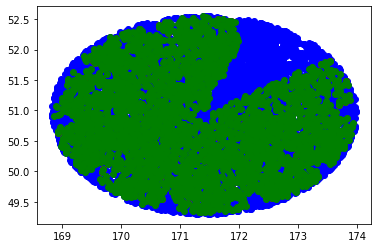

In [77]:
plt.plot(tart['RA'][wt],tart['DEC'][wt],'bo')
plt.plot(tart['RA'][wt&wd],tart['DEC'][wt&wd],'ro')
plt.plot(tart['RA'][wt&wp],tart['DEC'][wt&wp],'go')

In [71]:
len(tart[wt])

12581

In [82]:
len(tart[wt&wo])

2787

In [85]:
for ts in ['BGS|MORE_ZGOOD','BGS|MORE_ZWARN','BGS|UNOBS']:
    ws = tart['TARGET_STATE'] == ts
    print(ts,np.unique(tart[wt&ws]['PRIORITY']))

BGS|MORE_ZGOOD [1000]
BGS|MORE_ZWARN [2]
BGS|UNOBS [2000 2100]


In [ ]:
#how to remove a named column from a np array
#tar = tar[[b for b in list(tar.dtype.names) if b != 'Z']]